# Bayes PRF

Before running this notebook - install this package
(i.e., in the terminal, inside this folder run:
"pip install -e .")

You also need: 

* emcee               https://emcee.readthedocs.io/en/stable/user/install/

* prfpy               https://github.com/VU-Cog-Sci/prfpy.git (or https://github.com/spinoza-centre/prfpy_csenf.git if you want the contrast sensitivity function.)

* dag_prf_utils       https://github.com/mdaghlian/dag_prf_utils.git


Also a bit of an apology... There is some inconsistency in naming between prfpy and dag_prf_utils. I promise there is a good reason for this. I want prfpy to be backwards compatible. But, some names interfere with each other, when you start including other models (e.g., size, compared to size_1, and size_2 in the DN model). Here is the mapping for the gaussian model:

```
prfpy       dag_prf_utils

mu_x        x
mu_y        y
size        size_1
beta        amp_1
baseline    bold_baseline
hrf_1       hrf_deriv
hrf_2       hrf_disp


```

Most of the time you shouldn't have to think about it...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


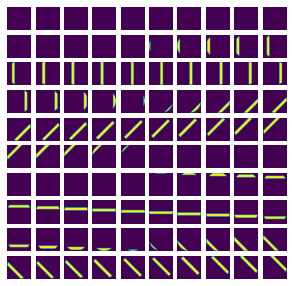

In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel
import os
import yaml
import pickle
from datetime import datetime

# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy')

# You can see we have a binarized matrix, of a bar moving across the screen...
fig = plt.figure()
rows = 10
cols = 10
fig.set_size_inches(5,5)
for i in range(100):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(dm[:,:,i], vmin=0, vmax=1)
    ax.axis('off')
# Now we need to enter the design matrix in a way that prfpy can read it. 
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,          # Distance of screen to eye
    screen_distance_cm=196,  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=1.5,                                  # TR
    )
# Now we can make the model
model = 'gauss'
prfpy_model = Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0])

# If for some reason you do not have the original dimensions, but you do have the dov, you can use this calculator:
# https://elvers.us/perception/visualAngle/ to make up some values for screen_size and distance, which will work...
# Load the runs

psc_runs = np.load('eg_data.npy')

# Stretch move - an emcee MCMC fitting method

In [85]:
from prfpy_bayes.prf_bayes import BayesPRF
# Start by making the bprf objects
bprf = BayesPRF(
    prf_params=None, # We could put in our best guess here, but we will let the model figure it out...
    model = 'gauss',
    prfpy_model=prfpy_model,
    real_ts=psc_runs,
    )
bounds = {
    'x': [-5, 5],
    'y': [-5, 5],
    'size_1': [0.1, 10],
    'amp_1': [0, 100],
    'bold_baseline': [0, 0],
    'hrf_deriv' : [4.6, 4.6],
    'hrf_disp' : [0, 0],
}
bprf.add_priors_from_bounds(bounds)
bprf.prep_info()
bprf.fit_voxel(
    initial_guess=[0,0,1,1],
    idx=0, 
    n_walkers=10,
    n_steps=500, 
    eps=1, 

)

prf_params.shape[-1]=8
include hrf = True
include rsq = True


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc

prf_params.shape[-1]=7
include hrf = True
include rsq = True


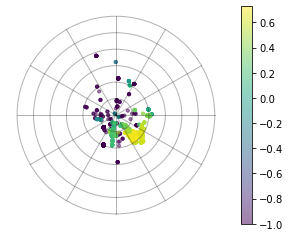

In [89]:
bprf.sampler[0].visual_field(
    dot_col='rsq', 
    th={},
    do_colbar=True,
    dot_vmin=-1, 
    dot_size=10,
)

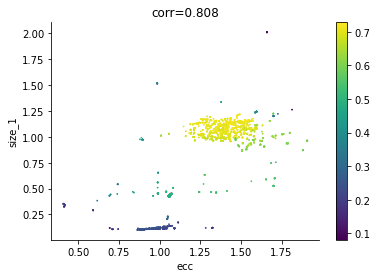

In [90]:
bprf.sampler[0].scatter(
    'ecc', 'size_1', pc='rsq', 
    th={'min-rsq':0, 'min-step_id':50}, 
    do_colbar=True,
    dot_size=.6,
    do_corr=True,
)

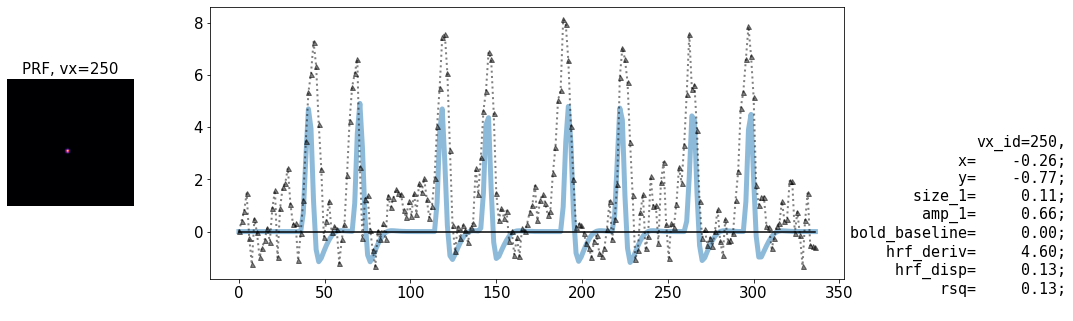

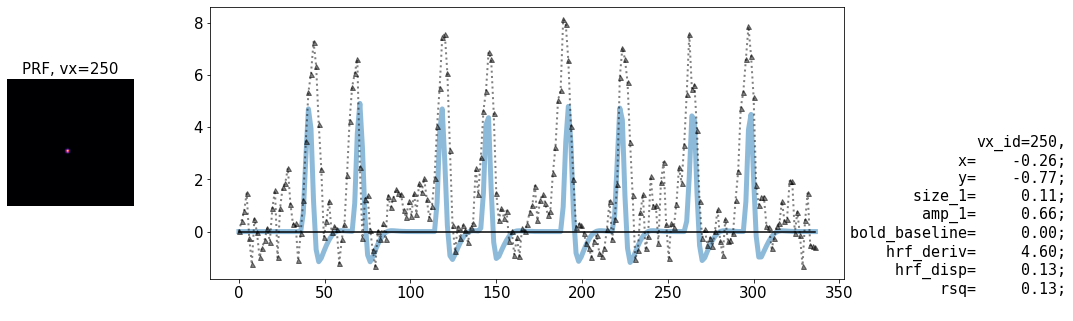

In [95]:
bprf.sampler[0].prf_ts_plot(250)

# GaussianMove

In [80]:
proposal_vect = [
    1,  # x 0        
    1,  # y 1
    1,  # sigma 2
    1, # amp_1 3
    # .1,   # hrf_deriv... (not given)
] # from adaszew...

import emcee
bprf.fit_voxel(
    initial_guess=[0,0,1,1],
    idx=0, 
    n_walkers=1,
    n_steps=2000, 
    eps=1, 
    kwargs_sampler={'moves':emcee.moves.GaussianMove(cov=proposal_vect, mode='vector')},
    kwargs_run = {'skip_initial_state_check':True},        
)

prf_params.shape[-1]=7
include hrf = True
include rsq = True


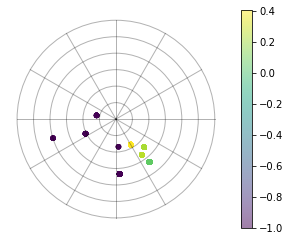

In [81]:
bprf.sampler[0].visual_field(
    dot_col='rsq', 
    th={},
    do_colbar=True,
    dot_vmin=-1, 
    dot_size=20,
)

In [ ]:
proposal_vect = [
    1,  # x 0        
    1,  # y 1
    1,  # sigma 2
    1, # amp_1 3
    # .1,   # hrf_deriv... (not given)
] # from adaszew...

n_ps = len(proposal_vect)
proposal_mat = np.zeros((n_ps, n_ps))
proposal_mat[np.arange(n_ps), np.arange(n_ps)] = proposal_vect
proposal_mat[2,3] = -10
proposal_mat = 1
with multiprocessing.Pool(processes=n_cpus) as pool:
    np.random.seed(42)
    sampler[model] = run_emcee_basic(
        n_walkers=n_walkers, 
        n_steps=n_steps, 
        true_resp=this_true_resp,
        bprf=bprf[model], 
        walkers=walkers,            
        pool=pool,            
        # kwargs_sampler={'moves':emcee.moves.GaussianMove(cov=proposal_mat, mode='vector')},
        # kwargs_sampler={'moves':emcee.moves.StretchMove()}, # emcee.moves.GaussianMove(cov=.1)},#emcee.moves.DESnookerMove()#emcee.moves.KDEMove()#emcee.moves.WalkMove() 
        # kwargs_run = {'skip_initial_state_check':True},
        )

# Measure the end time
end_time = time.time()

# Calculate and print the time taken
total_time = end_time - start_time
print("Total time taken: {:.1f} seconds".format(total_time))    
print(f'Model {model}, cpus={n_cpus}, walkers={n_walkers}, steps={n_steps}')
print(f'Acceptance rate = {sampler[model].acceptance_fraction}')
print(f'Acceptance rate = {sampler[model].acceptance_fraction.mean()}')

AttributeError: 'BayesPRF' object has no attribute 'sample_initial_params'

In [36]:
# x = np.random.randn(100,100,100,225)
# print(f'{x.size * x.itemsize / 1000000} mb')

print(bprf[model].init_p_id)

{'x': 0, 'y': 1, 'size_1': 2, 'amp_1': 3, 'hrf_deriv': 4}


In [27]:
class MPProposal():
    def __init__(self, radius_vf, mu_d, sigma_d):
        '''
        radius_vf       radius of visual field
        mu_d            for step_size distribution, mu
        sigma_d         for step_size distribution, sigma

        '''
        self.radius_vf = radius_vf
        self.mu_d = mu_d
        self.sigma_d = sigma_d
        





[ 0.75975191 -1.16022165  1.16207457  0.02010344  0.          2.7845381
  0.        ]


dict_items([('x', 0), ('y', 1), ('size_1', 2), ('amp_1', 3), ('amp_2', 4), ('size_2', 5), ('b_val', 6), ('d_val', 7)])
[ 7.57874089e-01 -1.13976050e+00  1.13333153e+00  2.96273654e+00
  0.00000000e+00  4.38510152e-02  5.83198799e+00  2.96680102e+00
  1.00003434e+02  2.78453810e+00  0.00000000e+00]


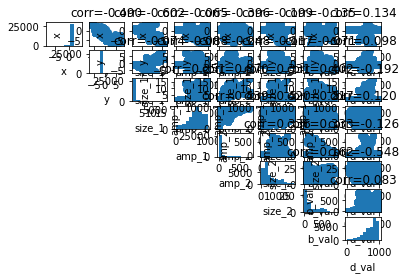

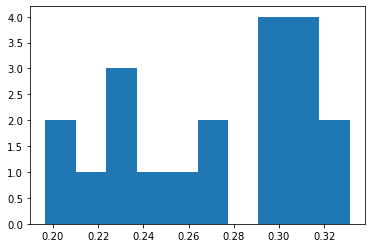

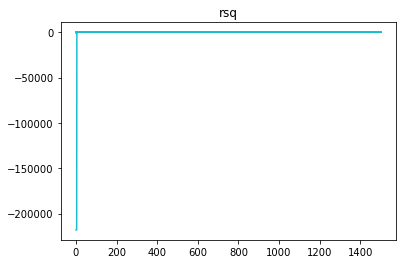

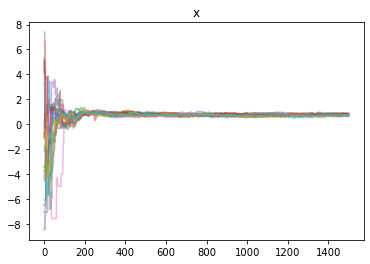

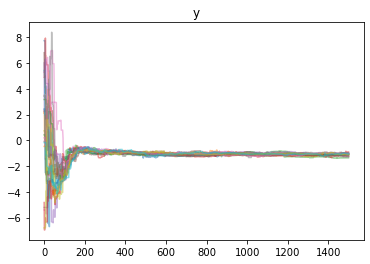

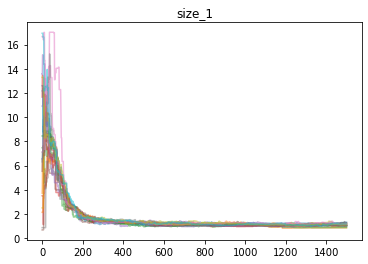

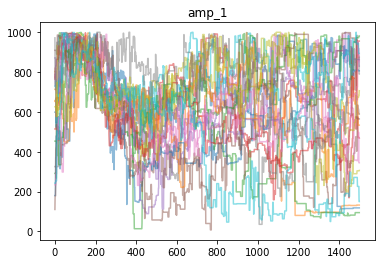

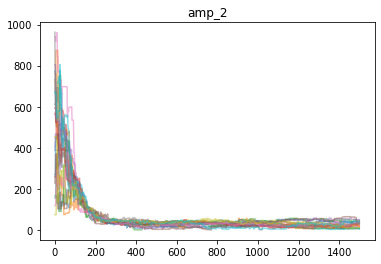

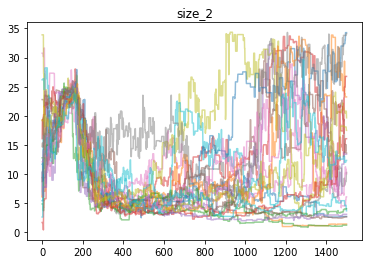

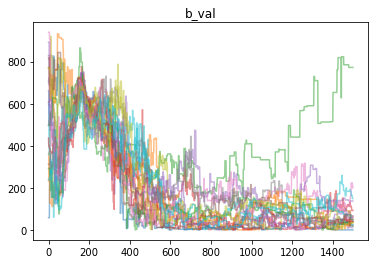

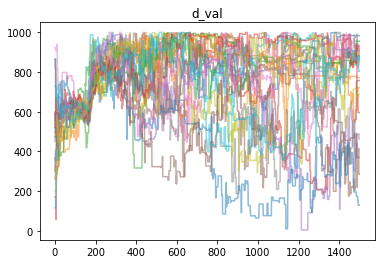

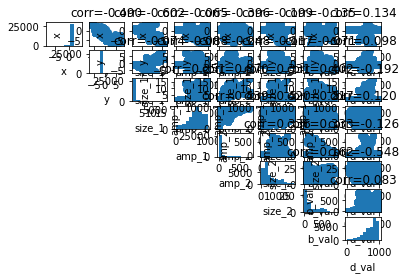

In [168]:

burn_in = 0
all_info = {}
model = 'gauss'
print(bprf[model].init_p_id.items())
all_info[model] = {
    'chain': sampler[model].get_chain(discard=burn_in, flat=False),
    'log_prob': sampler[model].get_log_prob(discard=burn_in, flat=False),
    'acceptance_fraction': sampler[model].acceptance_fraction,
    # 'acor': sampler[model].get_autocorr_time(),
    # Add any other information you want to store
}
all_info[model]['rsq'] = logprob2rsq(all_info[model]['log_prob'], this_true_resp)
flat_info = {}
flat_info[model] = {
    'chain': sampler[model].get_chain(discard=burn_in, flat=True),
    'log_prob': sampler[model].get_log_prob(discard=burn_in, flat=True),
    'acceptance_fraction': sampler[model].acceptance_fraction,
    # 'acor': sampler[model].get_autocorr_time(),
    # Add any other information you want to store
}
flat_info[model]['rsq'] = logprob2rsq(flat_info[model]['log_prob'], this_true_resp)

plt.hist(all_info[model]['acceptance_fraction'])
min_acc_frac = all_info[model]['acceptance_fraction']>0.1
plt.figure()
plt.title('rsq')
plt.plot(all_info[model]['rsq'])
for p_key,p_val in bprf[model].init_p_id.items():
    plt.figure()
    plt.title(p_key)
    a = plt.plot(all_info[model]['chain'][:,:,p_val], alpha=0.5)
print(this_cprf)





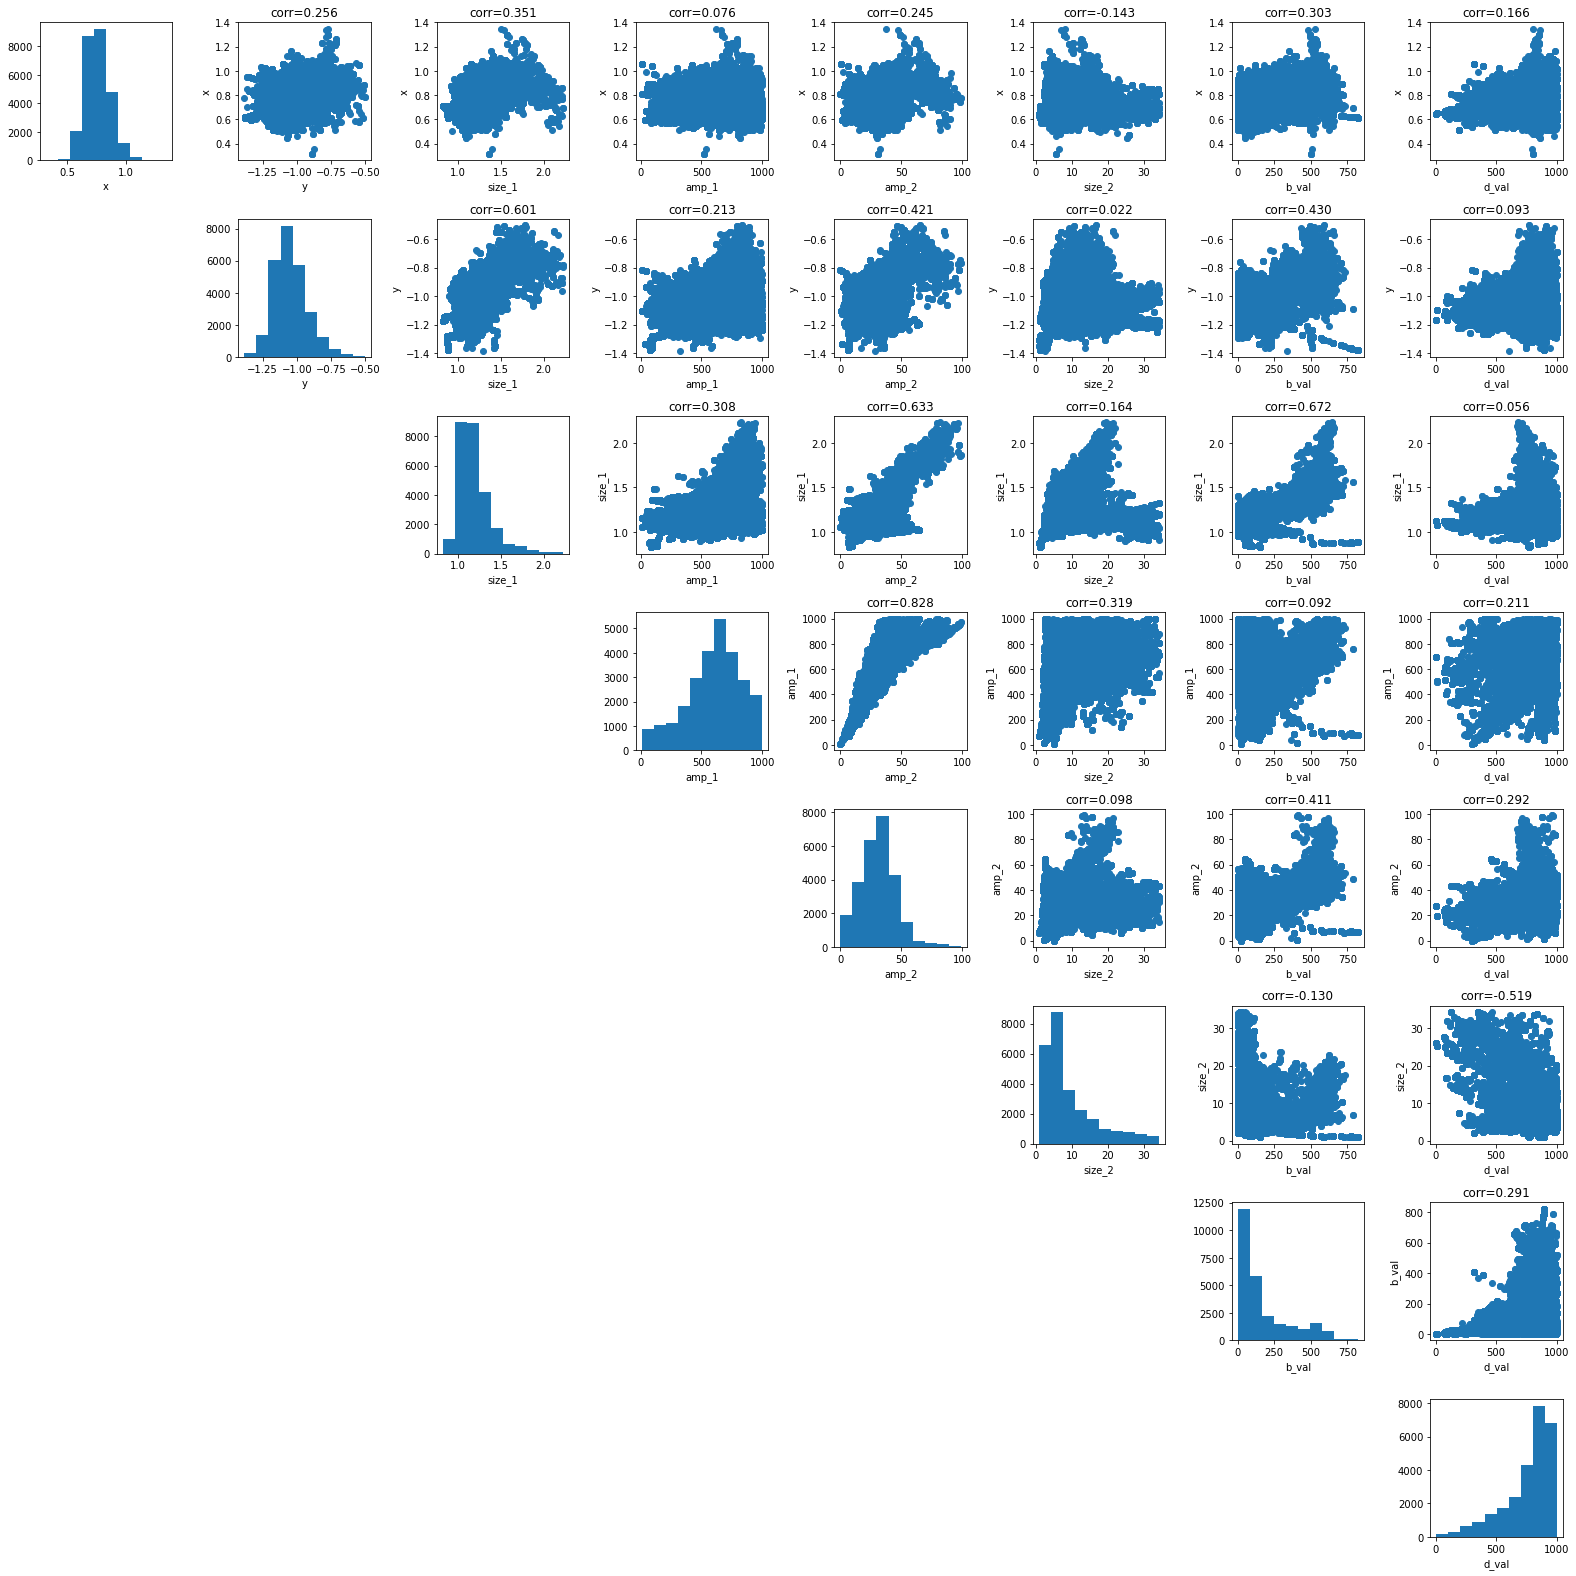

In [171]:
id_to_keep = flat_info[model]['rsq']>0.6
a = dag_multi_scatter(
    flat_info[model]['chain'][id_to_keep,:],
    p_labels=bprf[model].init_p_id.keys(),
)
a.set_size_inches(22,22)

In [57]:


# Define the number of CPUs you want to use for parallelization
n_cpus = 8  # You can change this number based on the available CPUs

# Define the batch number to parallelize over
batch_size = n_cpus  # You can change this number based on the number of iterations you want to run in parallel
total_n = 8

n_walkers = 80
n_steps = 10
sampler = {}
model = 'gauss'
start_time = time.time()
samples_pvx = []



# Function for processing a single "vx"
def process_ivx(ivx, real_tc, prf_data, bprf, n_walkers, n_steps, model):
    this_true_resp = real_tc[ivx, :]
    np.random.seed(ivx)
    this_cprf = prf_data[model][ivx, :-1]
    walkers = bprf[model].sample_tiny_gauss_ball(this_cprf, n_walkers)    
    # walkers = bprf[model].sample_initial_params(n_walkers)


    # this_sample = run_emcee_pervox(
    #     n_walkers=n_walkers,
    #     n_steps=n_steps,
    #     true_resp=this_true_resp,
    #     bprf=bprf[model],
    #     walkers=walkers,
    # )
    sampler = run_emcee_basic(
        n_walkers=n_walkers, 
        n_steps=n_steps, 
        true_resp=this_true_resp,
        bprf=bprf[model], 
        walkers=walkers,            
        # pool=pool,
        # moves=emcee.moves.WalkMove()
        )
    this_sample = {
        'chain': sampler.get_chain(discard=0, flat=False),
        'log_prob': sampler.get_log_prob(discard=0, flat=False),
        'acceptance_fraction': sampler.acceptance_fraction,
        # 'acor': sampler.get_autocorr_time(),
        # Add any other information you want to store
    }    

    return this_sample

# Loop through the batches of "vx" values
for batch_start in range(0, total_n, batch_size):
    batch_end = min(batch_start + batch_size, total_n)

    # Create a process pool based on the number of CPUs specified
    pool = multiprocessing.Pool(n_cpus)

    # Process each "vx" in the batch in parallel
    batch_vx = range(batch_start, batch_end)
    batch_results = pool.starmap(process_ivx, [(ivx, real_tc, prf_data, bprf, n_walkers, n_steps, model) for ivx in batch_vx])


    # Close the pool and wait for all tasks to complete
    pool.close()
    pool.join()

    # Collect the results from this batch separately and store in batch_samples_pvx
    batch_samples_pvx = []
    batch_samples_pvx.extend(batch_results)

    # Append the results from this batch to the main samples_pvx list
    samples_pvx.extend(batch_samples_pvx)
    
# Measure the end time
end_time = time.time()

# Calculate and print the time taken
total_time = end_time - start_time
print("Total time taken: {:.1f} seconds".format(total_time))
print(f'Model {model}, cpus={n_cpus}, walkers={n_walkers}, steps={n_steps}, \n batch_size={batch_size}, total_n={total_n}')


Total time taken: 23.8 seconds
Model gauss, cpus=8, walkers=80, steps=10, 
 batch_size=8, total_n=8


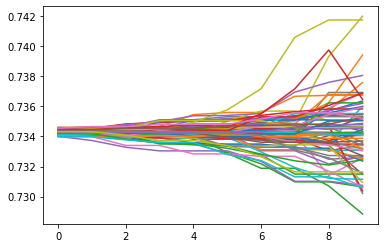

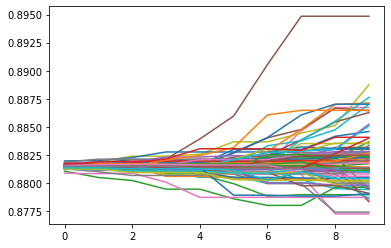

In [51]:
ivx = 1
burn_in = 0
ivx = 1
plt.plot(samples_pvx[1]['chain'][burn_in:,:,0])
# plt.plot(samples_pvx[ivx]['log_prob'])

plt.figure()
ivx = 5
plt.plot(samples_pvx[ivx]['chain'][burn_in:, :,0])

In [ ]:
print(f'{model}: {bprf[model].init_p_id}')
chain = sampler[model].get_chain()
log_prob = sampler[model].get_log_prob()

burn_in = 0
plt.plot(chain[burn_in:,:,4])
plt.figure()
plt.scatter(chain[burn_in:,:,2].ravel(), chain[burn_in:,:,4].ravel(), alpha=0.5)

In [73]:
burn_in = 0
all_info = {}
for model in model_list:
    all_info[model] = {
        'chain': sampler[model].get_chain(discard=burn_in, flat=True),
        'log_prob': sampler[model].get_log_prob(discard=burn_in, flat=True),
        'acceptance_fraction': sampler[model].acceptance_fraction,
        # 'acor': sampler.get_autocorr_time(),
        # Add any other information you want to store
    }
    break

In [ ]:
# # exclude inifinite
# is_finite = np.isfinite(all_info['log_prob'])
# all_info['log_prob'] = all_info['log_prob'][is_finite]
# all_info['chain'] = all_info['chain'][is_finite]

BPRF [ 7.75788006e-01 -1.09966714e+00  1.03199267e+00  1.13780246e+02
  5.99277763e+00  2.60507977e+00  1.61496837e-02  9.84535050e+02]
CPRF [ 7.57874089e-01 -1.13976050e+00  1.13333153e+00  2.96273654e+00
  0.00000000e+00  4.38510152e-02  5.83198799e+00  2.96680102e+00
  1.00003434e+02  2.78453810e+00  0.00000000e+00]
B rsq = 0.694
C rsq = 0.836


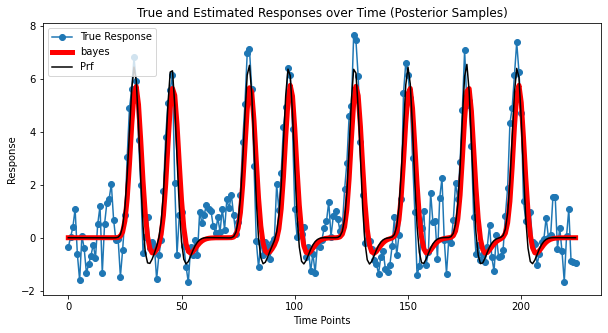

array([ 7.75788006e-01, -1.09966714e+00,  1.03199267e+00,  1.13780246e+02,
        5.99277763e+00,  2.60507977e+00,  1.61496837e-02,  9.84535050e+02])

In [165]:
def plot_mcmcfit(this_true_resp, this_cprf, all_info, model, bprf):
    # Extract estimated parameters (median of the samples)
    # MEDIAN
    top1 = all_info['log_prob'] >= np.percentile(all_info['log_prob'], 99.9)
    estimated_params = np.median(all_info['chain'][top1,:], axis=0)
    # estimated_params = np.median(all_info['chain'], axis=0)
    # estimated_params = all_info['chain'][-1,:]
    # WEIGHTED MEAN
    # weight = np.zeros_like(all_info['log_prob'])
    # id_finite = np.isfinite(all_info['log_prob'])
    # weight[id_finite] = all_info['log_prob'][id_finite] * -2
    # estimated_params = np.average(all_info['chain'], weights=1/weight, axis=0)
    # MAX NEGLL
    max_negLL = np.where(all_info['log_prob']==np.max(all_info['log_prob']))[0][0]
    estimated_params = all_info['chain'][max_negLL,:]
    # ...
    n_time_points = this_true_resp.shape[0]
    # Plot the true and estimated responses at different time points
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(n_time_points), this_true_resp, 'o-', label='True Response')
    # plt.figure()
    print(f'BPRF {estimated_params}')
    print(f'CPRF {this_cprf}')
    bprf_ts = bprf.prfpy_model_wrapper(estimated_params)
    cprf_ts = np.squeeze(prfpy_model[model].return_prediction(*list(this_cprf)))
    print(f'B rsq = {dag_get_rsq(this_true_resp, bprf_ts):.3f}')
    print(f'C rsq = {dag_get_rsq(this_true_resp, cprf_ts):.3f}')
    plt.plot(np.arange(n_time_points), bprf_ts, 'r-', label='bayes', lw=5,)
    for i in np.where(top1)[0][0:500]:
        plt.plot(np.arange(n_time_points), bprf.prfpy_model_wrapper(all_info['chain'][i,:]), 'r-', lw=1, alpha=0.1)
    plt.plot(np.arange(n_time_points), cprf_ts, 'k-', label='Prf')
    plt.xlabel('Time Points')
    plt.ylabel('Response')
    plt.legend()
    plt.title('True and Estimated Responses over Time (Posterior Samples)')
    plt.show()
    return estimated_params
model = 'norm'
this_cprf = prf_data[model][true_response_id,:-1]
plot_mcmcfit(this_true_resp, this_cprf, flat_info[model], model, bprf[model])    

In [ ]:
dag_multi_scatter(
    flat_info['chain']
)

In [ ]:
def incl_bestX(negLL, bestX):
    qX = np.percentile(negLL, bestX)
    incl_idx = negLL >= qX
    return incl_idx
# finite_id = np.isfinite(all_info['log_prob'])
print(this_cprf)
incl_idx = incl_bestX(all_info['log_prob'], 90)
plt.hist(all_info['chain'][incl_idx,8])
# plt.figure()
# plt.scatter(all_info['chain'][incl_idx,2], all_info['chain'][incl_idx,3])
# plt.figure()
# plt.scatter(all_info['chain'][incl_idx,2], all_info['chain'][incl_idx,4])

plt.figure()
plt.scatter(all_info['chain'][incl_idx,6], all_info['chain'][incl_idx,5])